In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import scipy.stats as stats
import scipy.signal as scsig
import scipy.io as scio
import h5py
import sharpy.utils.h5utils as h5utils
import sharpy.utils.algebra as algebra
import sharpy
mpl.rcParams['figure.dpi'] = 100
mpl.rcParams['figure.figsize'] = (8, 6)
%config InlineBackend.figure_format = 'retina'

In [2]:
S_ref = 32
u_inf = 10
rho = 1.225
qS = 0.5 * rho * u_inf ** 2 * S_ref

In [3]:
import os
sharpy_path = os.path.dirname(sharpy.__file__)


In [4]:
uvlm = np.loadtxt(sharpy_path + '/../tests/linear/inputsimulation/nonlinear_results.txt', skiprows=1, delimiter=',')
uvlm[:, 1:] /= qS

In [5]:
def process_linear(path_to_case, case_name, alpha0, alpha_min, alpha_max, n_evals, return_freq='D'):
    # load the aeroelastic system
    aoasys = scio.loadmat('{:s}/{:s}/{:s}.linss.mat'.format(path_to_case, case_name, case_name))
    # load the linearised uvlm
    uvlmsys = scio.loadmat('{:s}/{:s}/{:s}.uvlmss.mat'.format(path_to_case, case_name, case_name))
    
    
    # we need to compute the steady state transfer function of the discrete time uvlm
    H0 = uvlmsys['C'].dot(np.linalg.inv(np.eye(uvlmsys['A'].shape[0]) - uvlmsys['A']).dot(uvlmsys['B'])) + uvlmsys['D']
    
    cga = algebra.quat2rotation(algebra.euler2quat(np.array([0, alpha0, 0])))

    vx_ind = 20 # x_a input index
    vz_ind = 22 # z_a input index
    
    forces = np.zeros((n_evals, 4))
    for i_alpha, dalpha in enumerate(np.linspace(alpha_min, alpha_max, n_evals)-alpha0):
        alpha = alpha0 + dalpha  # rad
        deuler = np.array([0, dalpha, 0])
        euler0 = np.array([0, alpha0, 0])

        u = np.zeros((uvlmsys['B'].shape[1]))  # input vector
        V0 = np.array([-1, 0, 0], dtype=float) * u_inf  #G
        Vp = u_inf * np.array([-np.cos(dalpha), 0 , -np.sin(dalpha)])  #G
    
        dvg = Vp - V0  # G
        dva = cga.T.dot(dvg)  # A
        dvz = dva[2]
        dvx = dva[0]
        
        # Need to scale the mode shapes by the rigid body mode factor
        u[vx_ind] = dvx / aoasys['mode_shapes'][-9,0]
        u[vz_ind] = dvz / aoasys['mode_shapes'][-7,2]
        
        # and the same with the output forces
        flin = H0.dot(u)[:3].real / aoasys['mode_shapes'][-9,0]  # A
        F0A = aoasys['forces_aero_beam_dof'][0, :3] / aoasys['mode_shapes'][-9,0]  # A - forces at the linearisation
        LD0 = cga.dot(F0A)  # Lift and drag at the linearisation point
    
        forces[i_alpha, 0] = (alpha0 + dalpha) * 180 / np.pi # deg
        LD = LD0 + algebra.der_Ceuler_by_v(euler0, F0A).dot(deuler) + cga.dot(flin)  # stability axes
        forces[i_alpha, 1:] = LD / qS
    
    if return_freq=='freq':
        return H0
    elif return_freq=='D':
        return uvlmsys['D']
    elif return_freq=='B':
        return uvlmsys['B']
    else:
        return forces

In [6]:
linear_systems = []
path_to_systems = sharpy_path + '/../tests/linear/inputsimulation/src/output/'

for alpha in [2, 4]:
    case = {}
    case['alpha0'] = alpha
    case['case_name'] = 'simple_HALE_uvlm_alpha{:04g}_rom1_nmodes20'.format(case['alpha0']*100)
    case['path'] = path_to_systems + '/' + case['case_name']
    linear_systems.append(case)

In [7]:
for case in linear_systems:
    case['data'] = process_linear(case['path'], case['case_name'], alpha0=case['alpha0']*np.pi/180, alpha_min=0, alpha_max=5*np.pi/180, n_evals=11, return_freq='forces')
#     case['freq'] = process_linear(case['path'], case['case_name'], alpha0=case['alpha0']*np.pi/180, alpha_min=0, alpha_max=5*np.pi/180, n_evals=11, return_freq='freq')
#     case['D'] = process_linear(case['path'], case['case_name'], alpha0=case['alpha0']*np.pi/180, alpha_min=0, alpha_max=5*np.pi/180, n_evals=11, return_freq='D')
#     case['B'] = process_linear(case['path'], case['case_name'], alpha0=case['alpha0']*np.pi/180, alpha_min=0, alpha_max=5*np.pi/180, n_evals=11, return_freq='B')

Alpha0 = 2.0 deg
CL_alpha = 5.856429 / rad
CD_alpha @ alpha0 = 0.037433 / rad
Alpha0 = 4.0 deg
CL_alpha = 5.858438 / rad
CD_alpha @ alpha0 = 0.075219 / rad


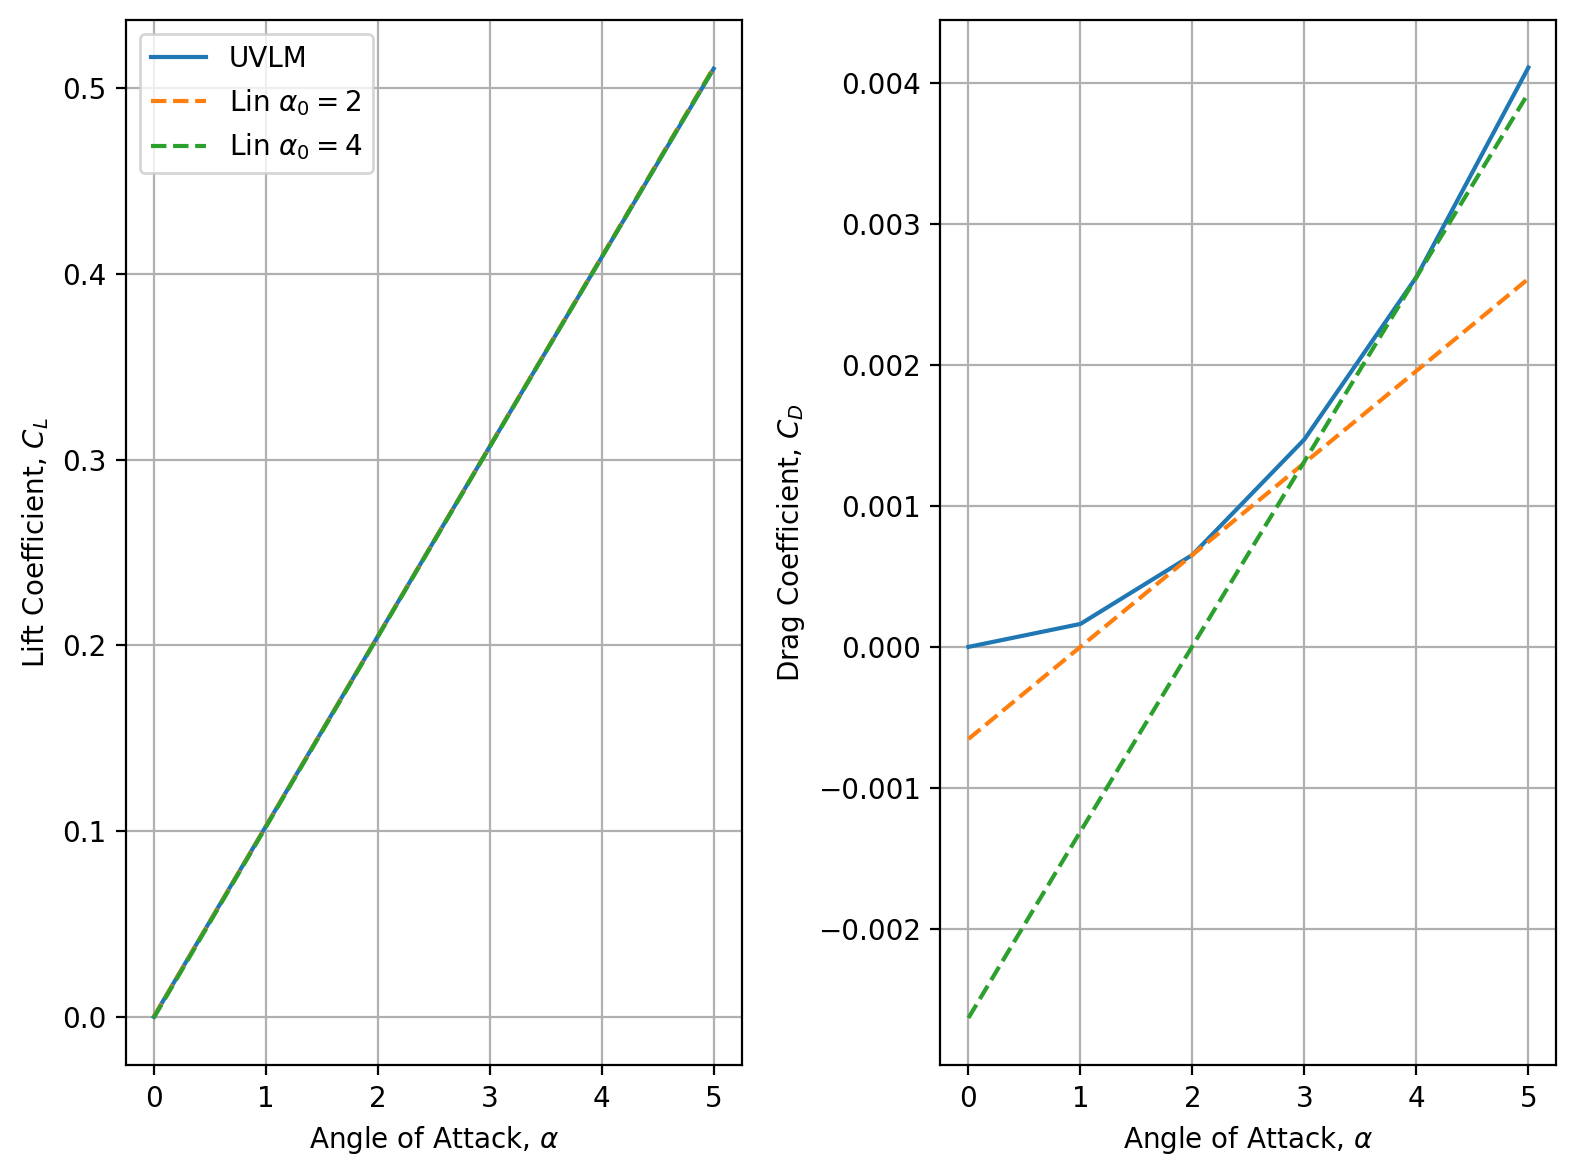

In [8]:
fig, ax = plt.subplots(ncols=2)

ax[0].plot(uvlm[:, 0], uvlm[:, -1], label='UVLM')
ax[1].plot(uvlm[:, 0], uvlm[:, 1])


for case in linear_systems:
    print('Alpha0 = {:.1f} deg'.format(case['alpha0']))
    ax[0].plot(case['data'][:, 0], case['data'][:, -1], ls='--', label=r'Lin $\alpha_0={:g}$'.format(case['alpha0']))
    ax[1].plot(case['data'][:, 0], case['data'][:, 1], ls='--')
    
    cla = (case['data'][-1, -1] - case['data'][0, -1]) / (case['data'][-1, 0] - case['data'][0, 0]) * 180/np.pi
    print('CL_alpha = {:3f} / rad'.format(cla))
    
    cda = (case['data'][-1, 1] - case['data'][0, 1]) / (case['data'][-1, 0] - case['data'][0, 0]) * 180/np.pi
    print('CD_alpha @ alpha0 = {:4f} / rad'.format(cda))

ax[0].set_ylabel('Lift Coefficient, $C_L$')
ax[1].set_ylabel('Drag Coefficient, $C_D$')

ax[0].set_xlabel(r'Angle of Attack, $\alpha$')
ax[1].set_xlabel(r'Angle of Attack, $\alpha$')


plt.tight_layout()
ax[0].grid()
ax[1].grid()
ax[0].legend()